In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
# Load VGG16 without the top layers
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

# Define the autoencoder model
model = models.Sequential(name='image_coloring_autoencoder_model')
# model.add(base_model)
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(layers.UpSampling2D((2, 2)))

# Compile the model
model.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])

In [3]:
TRAIN_DIR = "../input/train/"
TARGET_SIZE = (224, 224)
BATCH_SIZE = 16  # You can adjust this based on your GPU memory

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None
)


Found 7129 images belonging to 1 classes.


In [4]:
# # Convert RGB images to LAB format and separate L and AB channels
# def preprocess_lab(image_batch):
#     lab_batch = rgb2lab(image_batch)
#     X_batch = lab_batch[:, :, :, 0]  # L channel
#     Y_batch = lab_batch[:, :, :, 1:] / 128  # AB channels between -1 and 1
#     X_batch = X_batch.reshape(X_batch.shape + (1,))  # Add channel dimension for grayscale
#     return X_batch, Y_batch

# # Process the data in batches and extract VGG features
# def extract_vgg_features(generator, model):
#     vgg_features = []
#     for batch in generator:
#         X_batch, _ = preprocess_lab(batch)
#         vgg_batch = model.predict(gray2rgb(X_batch))
#         vgg_features.append(vgg_batch)
#         if len(vgg_features) * BATCH_SIZE >= len(generator.filenames):
#             break
#     return np.concatenate(vgg_features, axis=0)

# # Extract VGG features from the training data
# vgg_features = extract_vgg_features(train_generator, base_model)

# # Prepare Y (AB channels) for the decoder
# _, Y = preprocess_lab(train_generator.next())  # We only need the AB channels once

In [5]:
# # Convert RGB images to LAB format and separate L and AB channels
# def preprocess_lab(image_batch):
#     lab_batch = rgb2lab(image_batch)
#     X_batch = lab_batch[:, :, :, 0]  # L channel
#     Y_batch = lab_batch[:, :, :, 1:] / 128  # AB channels between -1 and 1
#     X_batch = X_batch.reshape(X_batch.shape + (1,))  # Add channel dimension for grayscale
#     return X_batch, Y_batch

# # Process the data in batches and extract VGG features
# def extract_vgg_features(generator, model):
#     vgg_features = []
#     for batch in generator:
#         X_batch, _ = preprocess_lab(batch)
#         vgg_batch = model.predict(batch, verbose=0)  # Use the original 3-channel image for VGG
#         vgg_features.append(vgg_batch)
#         if len(vgg_features) * BATCH_SIZE >= len(generator.filenames):
#             break
#     return np.concatenate(vgg_features, axis=0)

# # Extract VGG features from the training data
# vgg_features = extract_vgg_features(train_generator, base_model)

# # Prepare Y (AB channels) for the decoder
# _, Y = preprocess_lab(train_generator.next())  # We only need the AB channels once

In [6]:
%%time

# Convert RGB images to LAB format and separate L and AB channels
def preprocess_lab(image_batch):
    lab_batch = rgb2lab(image_batch)
    X_batch = lab_batch[:, :, :, 0]  # L channel
    Y_batch = lab_batch[:, :, :, 1:] / 128  # AB channels between -1 and 1
    X_batch = X_batch.reshape(X_batch.shape + (1,))  # Add channel dimension for grayscale
    return X_batch, Y_batch

# Process the data in batches and extract VGG features
def extract_vgg_features(generator, model):
    vgg_features = []
    Y_targets = []  # Collect the target data for each batch
    for batch in generator:
        X_batch, Y_batch = preprocess_lab(batch)
        vgg_batch = model.predict(batch, verbose=0)  # Use the original 3-channel image for VGG
        vgg_features.append(vgg_batch)
        Y_targets.append(Y_batch)
        if len(vgg_features) * BATCH_SIZE >= len(generator.filenames):
            break
    return np.concatenate(vgg_features, axis=0), np.concatenate(Y_targets, axis=0)

# Extract VGG features and target data from the training data
vgg_features, Y = extract_vgg_features(train_generator, base_model)

CPU times: total: 1min 46s
Wall time: 2min 14s


In [7]:
vgg_features.shape, Y.shape

((7129, 7, 7, 512), (7129, 224, 224, 2))

In [8]:
from tensorflow.keras.backend import clear_session
clear_session()

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Apply Early Stopping callback
early_stopping = EarlyStopping(monitor='loss', 
                               patience=20,
                               restore_best_weights=True)

In [12]:
%%time

# Train the decoder
history = model.fit(vgg_features, Y,
                    verbose=1,
                    epochs=2000, batch_size=16, 
                    callbacks=[early_stopping], workers=10)

Epoch 1/2000
446/446 [==============================] - 6s 10ms/step - loss: 0.0105 - accuracy: 0.6483
Epoch 2/2000
446/446 [==============================] - 4s 9ms/step - loss: 0.0071 - accuracy: 0.7116
Epoch 3/2000
446/446 [==============================] - 4s 9ms/step - loss: 0.0067 - accuracy: 0.7199
Epoch 4/2000
446/446 [==============================] - 4s 9ms/step - loss: 0.0063 - accuracy: 0.7265
Epoch 5/2000
446/446 [==============================] - 4s 10ms/step - loss: 0.0060 - accuracy: 0.7280
Epoch 6/2000
446/446 [==============================] - 4s 9ms/step - loss: 0.0057 - accuracy: 0.7341
Epoch 7/2000
446/446 [==============================] - 4s 9ms/step - loss: 0.0055 - accuracy: 0.7380
Epoch 8/2000
446/446 [==============================] - 4s 9ms/step - loss: 0.0054 - accuracy: 0.7392
Epoch 9/2000
446/446 [==============================] - 4s 9ms/step - loss: 0.0052 - accuracy: 0.7439
Epoch 10/2000
446/446 [==============================] - 4s 9ms/step - loss: 0.0

In [14]:
import os
os.makedirs("../output/saved_models", exist_ok=True)

model.save("../output/saved_models/new_autoencoder_2000_model")

INFO:tensorflow:Assets written to: ../output/saved_models/new_autoencoder_2000_model\assets


INFO:tensorflow:Assets written to: ../output/saved_models/new_autoencoder_2000_model\assets


In [15]:
from tensorflow.keras.backend import clear_session
clear_session()

In [16]:
test = img_to_array(load_img('../input/test/t1.jpg'))

test = resize(test, (224,224), anti_aliasing=True)
test*= 1.0/255

lab = rgb2lab(test)

l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1,224,224,3))

vgg_pred = base_model.predict(L)
ab = model.predict(vgg_pred)
ab = ab*128
cur = np.zeros((224, 224, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab

colored_img = lab2rgb(cur)

1/1 [==============================] - 0s 165ms/step


C:\Users\Amit Vikram Raj\AppData\Local\Temp\ipykernel_8696\3787011800.py:19: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 17366 negative Z values that have been clipped to zero
  colored_img = lab2rgb(cur)


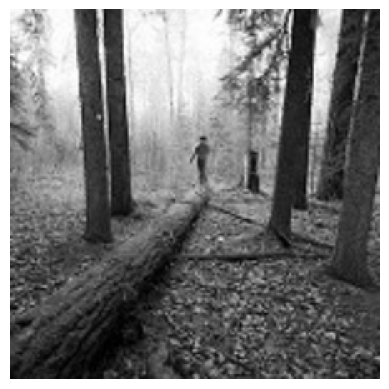

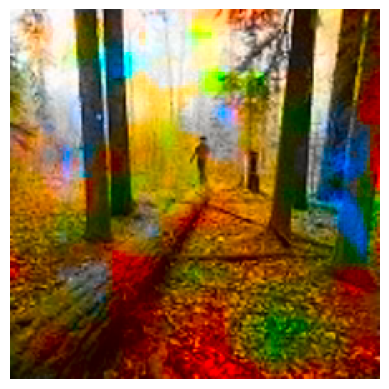

In [17]:
plt.figure()
plt.imshow(test)
plt.axis("off");

plt.figure()
plt.imshow(colored_img)
plt.axis("off");